<a href="https://colab.research.google.com/github/skbhat1234/Energy-Based-Models-for-Image-Resolution/blob/main/div2k_srgan2_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_mild.zip

In [ ]:
!unzip DIV2K_train_HR.zip

In [ ]:
!unzip DIV2K_train_LR_mild.zip

In [1]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 29.3 MB/s 
     |████████████████████████████████| 512 kB 97.6 MB/s 
     |████████████████████████████████| 125 kB 96.0 MB/s 


In [2]:
from __future__ import print_function, division
from torch.utils.data import Dataset
import os
import pandas as pd
import random
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import pytorch_lightning as pl
import glob 

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.tensorboard import SummaryWriter


# Torchvision
import torchvision
#from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision import models
from torchvision import transforms
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.model_selection import train_test_split


## Standard libraries
import os
import json
import math
import numpy as np 
import random

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

from tqdm.notebook import tqdm
import time



#Import metrics
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from statistics import mean


In [3]:
#Hyperparameters
#Set Batch Size
train_batch_size = 8

#epochs
epochs = 20

# Optimizer parameter
model_lr = 1e-4
model_betas = (0.9, 0.999)
model_eps = 1e-8
model_weight_decay = 0.0

# Loss weights
pixel_weight = 1.0
content_weight = 1.0
adversarial_weight = 0.001

# Dynamically adjust the learning rate policy [100,000 | 200,000]
lr_scheduler_step_size = epochs // 2
lr_scheduler_gamma = 0.1

# How many iterations to print the training result
train_print_frequency = 100
valid_print_frequency = 1

# Feature extraction layer parameter configuration
feature_model_extractor_node = "features.35"
feature_model_normalize_mean = [0.485, 0.456, 0.406]
feature_model_normalize_std = [0.229, 0.224, 0.225]

#Seed
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#Set Model Name
modelName = 'SRGAN2'

In [4]:
#Set paths

highRes = 'DIV2K_train_HR/'
lowRes = 'DIV2K_train_LR_mild/'
modelPath = 'models/' + modelName + '/'
outputPath = 'outputs/' + modelName + '/'
resultPath = 'results/' + modelName + '/'

hr_images = glob.glob(highRes + '*.png') #returns path of images
print(len(hr_images))

lr_images = glob.glob(lowRes + '*.png') #returns path of images
print(len(lr_images))

0
0


In [6]:
#create folders to store experiment results, models, outputs
if not os.path.exists(modelPath):
  os.makedirs(modelPath)

if not os.path.exists(outputPath):
  os.makedirs(outputPath)

if not os.path.exists(resultPath):
  os.makedirs(resultPath)  

In [ ]:
class FacesDataset(Dataset):
    def __init__(self, path, transform=None):
        #self.img_dir = path
        self.transform = transform
        self.image_path = path
        self.hr_transform = transforms.Compose(
        [
            transforms.Resize((256, 256)), 
            transforms.ToTensor(), # converts a 255 image to 0-1
        ])
        
        self.lr_transform = transforms.Compose(
        [
            transforms.Resize((256//4, 256//4)), 
            transforms.Resize((256, 256), Image.BICUBIC), 
            transforms.ToTensor()
            
            
        ])
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self,idx):
        image_hr = Image.open(self.image_path[idx][0])
        image_lr = Image.open(self.image_path[idx][1])

        image_lr = self.lr_transform(image_lr)
        image_hr = self.hr_transform(image_hr)
        
        return {"lr": image_lr, "hr": image_hr, 'img_name':self.image_path[idx][0].split('/')[-1]}
    
        
        
        

In [ ]:
def load_dataset():
  #Create Dataloaders
  train_paths, test_paths = train_test_split(sorted(zip(sorted(hr_images),sorted(lr_images))), test_size=0.02, random_state=42)

  train_dataloader = DataLoader(FacesDataset(train_paths), batch_size=train_batch_size, shuffle=True)
  test_dataloader = DataLoader(FacesDataset(test_paths), batch_size=1, shuffle = True)

  return train_dataloader, test_dataloader

In [ ]:
#load datasets
train_dataloader, test_dataloader = load_dataset()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
#Define ResNet architecture for Generator
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SRResNet18(nn.Module):
    def __init__(
        self,
        block=BasicBlock,
        num_blocks=[1, 1, 1, 1, 1],
        input_channel=64,
        channels=[64, 128, 256, 384, 3],
        #num_classes=1,
    ):

        super(ResNet, self).__init__()
        self.in_planes = input_channel

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, channels[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, channels[1], num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, channels[2], num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, channels[3], num_blocks[3], stride=1)
        self.layer5 = self._make_layer(block, channels[4], num_blocks[4], stride=1)
        #self.linear = nn.Linear(channels[3], 196608)#nn.Linear(channels[3]*4, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        # print(out.shape)
        #out = F.avg_pool2d(out, 16)
        # print(out.shape)
        #out = out.view(out.size(0), -1)
        #out = self.linear(out)
        return out


In [ ]:
#check model output
g_model = ResNet()

inp = torch.Tensor(1,3,256,256)
g_model(inp).shape

torch.Size([1, 3, 256, 256])

In [ ]:
del g_model

In [ ]:
#Define Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            # input size. (3) x 256 x 256
            nn.Conv2d(3, 64, (3, 3), (1, 1), (1, 1), bias=True),
            nn.LeakyReLU(0.2, True),
            # state size. (64) x 128 x 128
            nn.Conv2d(64, 64, (3, 3), (2, 2), (1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, (3, 3), (1, 1), (1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            # state size. (128) x 64 x 64
            nn.Conv2d(128, 128, (3, 3), (2, 2), (1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, (3, 3), (1, 1), (1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            # state size. (256) x 32 x 32
            nn.Conv2d(256, 256, (3, 3), (2, 2), (1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, (3, 3), (1, 1), (1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),
            # state size. (512) x 16 x 16
            nn.Conv2d(512, 512, (3, 3), (2, 2), (1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 16 * 16, 1024),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 1),
        )

    def forward(self, x: Tensor) :
        # Input image size must equal 96
        assert x.shape[2] == 256 and x.shape[3] == 256, "Image shape must equal 256 X 256"

        out = self.features(x)
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        return out

In [ ]:
d_model = Discriminator()

In [ ]:
#Print number of generator and discriminator Parameters
print('Generator - g_model: ', sum(p.numel() for p in g_model.parameters() if p.requires_grad), ' parameters')
print('Discriminator - d_model: ', sum(p.numel() for p in d_model.parameters() if p.requires_grad), ' parameters')

Generator - g_model:  3549091  parameters
Discriminator - d_model:  138907009  parameters


In [ ]:
del d_model, g_model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
#Define class for content loss using VGG 16

class _ContentLoss(nn.Module):
    """Constructs a content loss function based on the VGG19 network.
    Using high-level feature mapping layers from the latter layers will focus more on the texture content of the image.
    Paper reference list:
        -`Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network <https://arxiv.org/pdf/1609.04802.pdf>` paper.
        -`ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks                    <https://arxiv.org/pdf/1809.00219.pdf>` paper.
        -`Perceptual Extreme Super Resolution Network with Receptive Field Block               <https://arxiv.org/pdf/2005.12597.pdf>` paper.
     """

    def __init__(
            self,
            feature_model_extractor_node: str,
            feature_model_normalize_mean: list,
            feature_model_normalize_std: list
    ):
        super(_ContentLoss, self).__init__()
        # Get the name of the specified feature extraction node
        self.feature_model_extractor_node = feature_model_extractor_node
        # Load the VGG19 model trained on the ImageNet dataset.
        model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
        # Extract the thirty-sixth layer output in the VGG19 model as the content loss.
        self.feature_extractor = create_feature_extractor(model, [feature_model_extractor_node])
        # set to validation mode
        self.feature_extractor.eval()

        # The preprocessing method of the input data. 
        # This is the VGG model preprocessing method of the ImageNet dataset.
        self.normalize = transforms.Normalize(feature_model_normalize_mean, feature_model_normalize_std)

        # Freeze model parameters.
        for model_parameters in self.feature_extractor.parameters():
            model_parameters.requires_grad = False

    def forward(self, sr_tensor: Tensor, gt_tensor: Tensor):
        # Standardized operations
        sr_tensor = self.normalize(sr_tensor)
        gt_tensor = self.normalize(gt_tensor)

        sr_feature = self.feature_extractor(sr_tensor)[self.feature_model_extractor_node]
        gt_feature = self.feature_extractor(gt_tensor)[self.feature_model_extractor_node]

        # Find the feature map difference between the two images
        loss = F.mse_loss(sr_feature, gt_feature)

        return loss


In [ ]:
def build_model():
  #Generator
  g_model = ResNet().to(device = device)



  #Discriminator
  d_model = Discriminator().to(device = device)

  return d_model, g_model

In [ ]:
def define_loss():
    pixel_criterion = nn.MSELoss()
    content_criterion = _ContentLoss(feature_model_extractor_node=feature_model_extractor_node,
                                           feature_model_normalize_mean=feature_model_normalize_mean,
                                           feature_model_normalize_std=feature_model_normalize_std)
    adversarial_criterion = nn.BCEWithLogitsLoss()

    # Transfer to CUDA
    pixel_criterion = pixel_criterion.to(device)
    content_criterion = content_criterion.to(device)
    adversarial_criterion = adversarial_criterion.to(device)

    return pixel_criterion, content_criterion, adversarial_criterion

In [ ]:
def define_optimizer(d_model, g_model):
    d_optimizer = optim.Adam(d_model.parameters(),
                             model_lr,
                             model_betas,
                             model_eps,
                             model_weight_decay)
    g_optimizer = optim.Adam(g_model.parameters(),
                             model_lr,
                             model_betas,
                             model_eps,
                             model_weight_decay)
    
    return d_optimizer, g_optimizer

In [ ]:
def define_scheduler(d_optimizer, g_optimizer):
    d_scheduler = lr_scheduler.StepLR(d_optimizer,
                                      lr_scheduler_step_size,
                                      lr_scheduler_gamma)
    g_scheduler = lr_scheduler.StepLR(g_optimizer,
                                      lr_scheduler_step_size,
                                      lr_scheduler_gamma)
    return d_scheduler, g_scheduler

In [ ]:
def training_step(
        d_model,
        g_model,
        train_dataloader,
        pixel_criterion,
        content_criterion,
        adversarial_criterion,
        d_optimizer,
        g_optimizer,
        psnr_model,
        ssim_model,
        epoch,
        writer
    ):
    
    
    # Calculate how many batches of data are in each Epoch
    num_batches = len(train_dataloader)

    #initialize performance metrics lists
    d_losses = []
    g_losses = []
    pixel_losses = [] 
    content_losses = [] 
    adversarial_losses = [] 
    d_hr_probabilities = [] 
    d_fk_probabilities = [] 
    psnrs = []
    ssims = []

    # Put the adversarial network model in training mode
    d_model.train()
    g_model.train()

    # initialize dataloader as an iterator
    dataloader_iter = iter(train_dataloader)

    for i in tqdm(range(num_batches)):
        #get batch
        batch_data = next(dataloader_iter)

        # Transfer in-memory data to CUDA devices to speed up training
        hr = batch_data["hr"].to(device=device)
        lr = batch_data["lr"].to(device=device)

        # Set the real sample label to 1, and the false sample label to 0
        batch_size, _, height, width = hr.shape
        real_label = torch.full([batch_size, 1], 1.0, dtype=hr.dtype, device=device)
        fake_label = torch.full([batch_size, 1], 0.0, dtype=hr.dtype, device=device)

        # Start training the discriminator model
        # During discriminator model training, enable discriminator model backpropagation
        for d_parameters in d_model.parameters():
            d_parameters.requires_grad = True

        # Initialize the discriminator model gradients
        d_model.zero_grad(set_to_none=True)

        # Calculate the classification score of the discriminator model for real samples
        hr_output = d_model(hr)
        d_loss_hr = adversarial_criterion(hr_output, real_label)
        # Call the gradient scaling function in the mixed precision API to
        # back-propagate the gradient information of the fake samples
        d_loss_hr.backward(retain_graph=True)

        # Calculate the classification score of the discriminator model for fake samples
        # Use the generator model to generate fake samples
        fk = g_model(lr)
        fk_output = d_model(fk.detach().clone())
        d_loss_fk = adversarial_criterion(fk_output, fake_label)
        # Call the gradient scaling function in the mixed precision API to
        # back-propagate the gradient information of the fake samples
        d_loss_fk.backward()

        # Calculate the total discriminator loss value
        d_loss = d_loss_hr + d_loss_fk

        # Improve the discriminator model's ability to classify real and fake samples
        d_optimizer.step()
        # Finish training the discriminator model

        # Start training the generator model
        # During generator training, turn off discriminator backpropagation
        for d_parameters in d_model.parameters():
            d_parameters.requires_grad = False

        # Initialize generator model gradients
        g_model.zero_grad(set_to_none=True)

        # Calculate the perceptual loss of the generator, mainly including pixel loss, feature loss and adversarial loss
        pixel_loss = pixel_weight * pixel_criterion(fk, hr)
        content_loss = content_weight * content_criterion(fk, hr)
        adversarial_loss = adversarial_weight * adversarial_criterion(d_model(fk), real_label)

        # Calculate psnr and ssim
        psnr_train = psnr_model(hr.permute(0, 2, 3, 1).detach().cpu().numpy(), fk.permute(0, 2, 3, 1).detach().cpu().numpy())
        ssim_train = ssim_model(hr.permute(0, 2, 3, 1).detach().cpu().numpy(), fk.permute(0, 2, 3, 1).detach().cpu().numpy(), multichannel = True)

        # Calculate the generator total loss value
        g_loss = pixel_loss + content_loss + adversarial_loss
        # Call the gradient scaling function in the mixed precision API to
        # back-propagate the gradient information of the fake samples
        g_loss.backward()

        # Encourage the generator to generate higher quality fake samples, making it easier to fool the discriminator
        g_optimizer.step()
        # Finish training the generator model

        # Calculate the score of the discriminator on real samples and fake samples,
        # the score of real samples is close to 1, and the score of fake samples is close to 0
        d_hr_probability = torch.sigmoid_(torch.mean(hr_output.detach()))
        d_fk_probability = torch.sigmoid_(torch.mean(fk_output.detach()))

        # Statistical accuracy and loss value for terminal data output
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        pixel_losses.append(pixel_loss.item()) 
        content_losses.append(content_loss.item()) 
        adversarial_losses.append(adversarial_loss.item()) 
        d_hr_probabilities.append(d_hr_probability.item()) 
        d_fk_probabilities.append(d_fk_probability.item()) 
        psnrs.append(psnr_train)
        ssims.append(ssim_train)

        # Write the data during training to the training log file
        if i % train_print_frequency == 0:
            iters = i + epoch * num_batches + 1
            writer.add_scalar("Train/D_Loss", d_loss.item(), iters)
            writer.add_scalar("Train/G_Loss", g_loss.item(), iters)
            writer.add_scalar("Train/Pixel_Loss", pixel_loss.item(), iters)
            writer.add_scalar("Train/Content_Loss", content_loss.item(), iters)
            writer.add_scalar("Train/Adversarial_Loss", adversarial_loss.item(), iters)
            writer.add_scalar("Train/D(HR)_Probability", d_hr_probability.item(), iters)
            writer.add_scalar("Train/D(FK)_Probability", d_fk_probability.item(), iters)
            writer.add_scalar("Train/PSNR", psnr_train, iters)
            writer.add_scalar("Train/SSIM", ssim_train, iters)
            
        del hr, lr, fk, d_loss, g_loss, pixel_loss, content_loss, adversarial_loss, d_hr_probability, d_fk_probability, psnr_train, ssim_train
        torch.cuda.empty_cache()
    
    return (mean(d_losses),
           mean(g_losses), 
           mean(pixel_losses), 
           mean(content_losses), 
           mean(adversarial_losses), 
           mean(d_hr_probabilities), 
           mean(d_fk_probabilities),
           mean(psnrs),
           mean(ssims))

In [ ]:
def validation_step(
        g_model,
        valid_dataloader,
        epoch,
        writer,
        psnr_model,
        ssim_model,
        mode
    ):
    # Initialize lists for storing metrics
    psnres = [] 
    ssimes = [] 

    # Put the adversarial network model in validation mode
    g_model.eval()

    # Initialize the number of data batches to print logs on the terminal
    batch_index = 0

    # get length of dataloader
    n = len(valid_dataloader)

    # initialize dataloader as an iterator
    dataloader_iter = iter(valid_dataloader)

    with torch.no_grad():
        for i in tqdm(range(n)):
        # while batch_data is not None:
            
            #get batch
            batch_data = next(dataloader_iter)
            
            # Transfer the in-memory data to the CUDA device to speed up the test
            hr = batch_data["hr"].to(device)
            lr = batch_data["lr"].to(device)

            # Use the generator model to generate a fake sample
            fk = g_model(lr)

            # Statistical loss value for terminal data output
            psnr = psnr_model(hr[0].permute(1, 2, 0).cpu().numpy(), fk[0].permute(1, 2, 0).cpu().numpy())
            ssim = ssim_model(hr[0].permute(1, 2, 0).cpu().numpy(), fk[0].permute(1, 2, 0).cpu().numpy(), multichannel = True)
            psnres.append(psnr) 
            ssimes.append(ssim) 


            del hr, lr, fk, psnr, ssim
            torch.cuda.empty_cache()

    if mode == "Valid" or mode == "Test":
        writer.add_scalar(f"{mode}/PSNR", mean(psnres), epoch + 1)
        writer.add_scalar(f"{mode}/SSIM", mean(ssimes), epoch + 1)
    else:
        raise ValueError("Unsupported mode, please use `Valid` or `Test`.")

    return mean(psnres), mean(ssimes)

In [ ]:
def save_train_summary(epochs, train_d_losses, train_g_losses, train_pixel_losses, train_content_losses, 
                       train_adversarial_losses, train_d_hr_probabilities, train_d_fk_probabilities, train_psnrs,
                       train_ssims, val_psnrs, val_ssims):

  epoch_range = [i for i in range(epochs)]

  df = pd.DataFrame(list(zip(epoch_range,
                             train_d_losses,
                             train_g_losses,
                             train_pixel_losses,
                             train_content_losses,
                             train_adversarial_losses,
                             train_d_hr_probabilities,
                             train_d_fk_probabilities,
                             train_psnrs,
                             train_ssims,
                             val_psnrs,
                             val_ssims)),
                    columns = ['epoch', 'train_d_loss', 'train_g_loss', 'train_pixel_loss', 'train_content_loss', 'train_adversarial_loss',
                               'train_d_hr_probability', 'train_d_fk_probability', 'train_psnr', 'train_ssim', 'val_psnr', 'val_ssim'])
  
  df.to_csv(resultPath + 'TrainSummary_SRGAN2.csv')


In [ ]:
def train_model(epochs = 10):

  # initialize training to generate network evaluation indicators
  best_psnr = 0.0
  best_ssim = 0.0

  #Initiate lists for performance summary
  train_d_losses = [] 
  train_g_losses = []
  train_pixel_losses = [] 
  train_content_losses = []
  train_adversarial_losses = [] 
  train_d_hr_probabilities = []
  train_d_fk_probabilities = []
  train_psnrs = []
  train_ssims = []
  val_psnrs = []
  val_ssims = []

  # load Model
  d_model, g_model = build_model()

  # load Dataset
  train_dataloader, test_dataloader = load_dataset()

  # load loss functions
  pixel_criterion, content_criterion, adversarial_criterion = define_loss()

  # load optimizers
  d_optimizer, g_optimizer = define_optimizer(d_model, g_model)

  # load schedulers
  d_scheduler, g_scheduler = define_scheduler(d_optimizer, g_optimizer)

  # check if pre-trained model already exists, if yes then load
  if os.path.exists(modelPath + 'best_d_model_srgan2.pkl'):
    d_model.load_state_dict(torch.load(modelPath + 'best_d_model_srgan2.pkl')['model_state_dict'])
  
  if os.path.exists(modelPath + 'best_g_model_srgan2.pkl'):
    g_model.load_state_dict(torch.load(modelPath + 'best_g_model_srgan2.pkl')['model_state_dict'])


  # Create training process log file
  writer = SummaryWriter(resultPath + 'SRGAN2_summary')

  # note train loop start time
  train_loop_start_time = time.time()

  for epoch in range(epochs):

      print('\nEpoch: ', epoch, '.....')

      train_start_time = time.time()

      print('Training....')
      # take a training step
      (d_loss, 
      g_loss, 
      pixel_loss, 
      content_loss, 
      adversarial_loss, 
      d_hr_probability, 
      d_fk_probability,
      psnr_train,
      ssim_train) = training_step(d_model,
                                        g_model,
                                        train_dataloader,
                                        pixel_criterion,
                                        content_criterion,
                                        adversarial_criterion,
                                        d_optimizer,
                                        g_optimizer,
                                        peak_signal_noise_ratio,
                                        structural_similarity,
                                        epoch,
                                        writer)

      #add to performance summary lists
      train_d_losses.append(d_loss) 
      train_g_losses.append(g_loss) 
      train_pixel_losses.append(pixel_loss) 
      train_content_losses.append(content_loss) 
      train_adversarial_losses.append(adversarial_loss)
      train_d_hr_probabilities.append(d_hr_probability)
      train_d_fk_probabilities.append(d_fk_probability)
      train_psnrs.append(psnr_train)
      train_ssims.append(ssim_train)
      
      #note training end time and val start time
      train_end_time = time.time()
      
      #Print Training time
      print('Training completed in ', float(train_end_time - train_start_time)/60.0, ' mins')

      print('Validation....')
      # take a validation step
      psnr_val, ssim_val = validation_step(g_model,
                                           test_dataloader,
                                           epoch,
                                           writer,
                                           peak_signal_noise_ratio, 
                                           structural_similarity, 
                                           'Valid')

      #add to performance summary lists
      val_psnrs.append(psnr_val)
      val_ssims.append(ssim_val)

      #note val end time
      val_end_time = time.time()

      #Print validation time
      print('Validation completed in ', float(val_end_time - train_end_time)/60.0, ' mins')

      #Print Validation Performance
      print('Epoch: ', epoch, '---> Validation PSNR: ', psnr_val)
      print('Epoch: ', epoch, '---> Validation SSIM: ', ssim_val)

      # Update LR
      d_scheduler.step()
      g_scheduler.step()


      # if avg psnr/ssim improved, then save model
      if psnr_val > best_psnr or ssim_val > best_ssim:
        best_psnr = max(psnr_val, best_psnr)
        best_ssim = max(ssim_val, best_ssim)

        print('Saving model ...')
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': d_model.state_dict(),
                    'optimizer_state_dict': d_optimizer.state_dict(),
                    'scheduler': d_scheduler,
                    'd_loss': d_loss, 
                    'pixel_loss': pixel_loss, 
                    'content_loss': content_loss, 
                    'adversarial_losses': adversarial_loss, 
                    'd_hr_probability': d_hr_probability, 
                    'd_fk_probability': d_fk_probability
                  }
                  , modelPath + 'best_d_model_srgan2.pkl')
        
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': g_model.state_dict(),
                    'optimizer_state_dict': g_optimizer.state_dict(), 
                    'scheduler':g_scheduler,
                    'g_loss': g_loss, 
                    'pixel_loss': pixel_loss, 
                    'content_loss': content_loss, 
                    'adversarial_losses': adversarial_loss, 
                    'd_hr_probability': d_hr_probability, 
                    'd_fk_probability': d_fk_probability
                  }
                  , modelPath + 'best_g_model_srgan2.pkl')
    

  #Save Performance metrics
  save_train_summary(epochs,
                     train_d_losses,
                     train_g_losses,
                     train_pixel_losses,
                     train_content_losses,
                     train_adversarial_losses,
                     train_d_hr_probabilities,
                     train_d_fk_probabilities,
                     train_psnrs,
                     train_ssims,
                     val_psnrs,
                     val_ssims)


  #Testing

  print('Testing....')
  
  #note test start time
  test_start_time = time.time()

  #Load Best Model
  g_model.load_state_dict(torch.load(modelPath + 'best_g_model_srgan2.pkl')['model_state_dict'])

  #run testing loop
  psnr_testing, ssim_testing = validation_step(g_model,
                                               test_dataloader,
                                               epoch,
                                               writer,
                                               peak_signal_noise_ratio, 
                                               structural_similarity, 
                                               'Test')  
  
  #note test end time
  test_end_time = time.time()
  
  #Print testing time and performance
  print('Testing completed in ', float(test_end_time - test_start_time)/60.0, ' mins')
  print('\nTest PSNR: ', psnr_testing)
  print('Test SSIM: ', ssim_testing)

  # Note and Print total loop time
  train_loop_end_time = time.time()
  print('\nTotal Model Training Time: ', float(train_loop_end_time - train_loop_start_time)/60.0, ' mins')

In [ ]:
#Train the model for certain epochs
train_model(epochs)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]


Epoch:  0 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.6743674914042157  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04304466644922892  mins
Epoch:  0 ---> Validation PSNR:  11.17186827086751
Epoch:  0 ---> Validation SSIM:  0.3150808822456335
Saving model ...

Epoch:  1 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.5573806405067443  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04294580618540446  mins
Epoch:  1 ---> Validation PSNR:  12.675317001615475
Epoch:  1 ---> Validation SSIM:  0.41953413506066517
Saving model ...

Epoch:  2 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.534907074769338  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.042868399620056154  mins
Epoch:  2 ---> Validation PSNR:  13.391121013031377
Epoch:  2 ---> Validation SSIM:  0.4419108008744751
Saving model ...

Epoch:  3 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.5365420540173846  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04286689758300781  mins
Epoch:  3 ---> Validation PSNR:  15.624362579280346
Epoch:  3 ---> Validation SSIM:  0.539327782529964
Saving model ...

Epoch:  4 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.5365806500116985  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04276826779047648  mins
Epoch:  4 ---> Validation PSNR:  16.541552607619682
Epoch:  4 ---> Validation SSIM:  0.5765254664814824
Saving model ...

Epoch:  5 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.549800169467926  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04259185393651326  mins
Epoch:  5 ---> Validation PSNR:  16.066168810734048
Epoch:  5 ---> Validation SSIM:  0.5569240724212076

Epoch:  6 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.540264304478963  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.043501714865366616  mins
Epoch:  6 ---> Validation PSNR:  16.67323828727032
Epoch:  6 ---> Validation SSIM:  0.5793170747658648
Saving model ...

Epoch:  7 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.54636557896932  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.043043049176534016  mins
Epoch:  7 ---> Validation PSNR:  17.522259894103804
Epoch:  7 ---> Validation SSIM:  0.6207693901741654
Saving model ...

Epoch:  8 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.5442186832427978  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.0427595059076945  mins
Epoch:  8 ---> Validation PSNR:  17.41639487693767
Epoch:  8 ---> Validation SSIM:  0.6139930539170755

Epoch:  9 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.529162359237671  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04256406625111898  mins
Epoch:  9 ---> Validation PSNR:  17.99598383501994
Epoch:  9 ---> Validation SSIM:  0.6318305365058394
Saving model ...

Epoch:  10 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.5435128092765806  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04312288761138916  mins
Epoch:  10 ---> Validation PSNR:  17.350822000261868
Epoch:  10 ---> Validation SSIM:  0.6144105128489832

Epoch:  11 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.53092059691747  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04282596508661906  mins
Epoch:  11 ---> Validation PSNR:  18.42445140827841
Epoch:  11 ---> Validation SSIM:  0.6401985569167217
Saving model ...

Epoch:  12 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.540249212582906  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04296684662501017  mins
Epoch:  12 ---> Validation PSNR:  18.044984722985618
Epoch:  12 ---> Validation SSIM:  0.6356093244292613

Epoch:  13 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.5409192005793253  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.0428876797358195  mins
Epoch:  13 ---> Validation PSNR:  18.712173652004907
Epoch:  13 ---> Validation SSIM:  0.6552451073001201
Saving model ...

Epoch:  14 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.552083106835683  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04284800291061401  mins
Epoch:  14 ---> Validation PSNR:  18.803059600090343
Epoch:  14 ---> Validation SSIM:  0.6464348173292827
Saving model ...

Epoch:  15 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.545940399169922  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04269424279530843  mins
Epoch:  15 ---> Validation PSNR:  17.647866187181286
Epoch:  15 ---> Validation SSIM:  0.6274932236131603

Epoch:  16 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.526580500602722  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04261438846588135  mins
Epoch:  16 ---> Validation PSNR:  18.1481085359598
Epoch:  16 ---> Validation SSIM:  0.6384163355661174

Epoch:  17 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.5364428718884784  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04292808373769124  mins
Epoch:  17 ---> Validation PSNR:  17.900680388409132
Epoch:  17 ---> Validation SSIM:  0.6342113793873028

Epoch:  18 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.5189329783121743  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.04252101182937622  mins
Epoch:  18 ---> Validation PSNR:  18.804496746051875
Epoch:  18 ---> Validation SSIM:  0.6505142857776179
Saving model ...

Epoch:  19 .....
Training....


  0%|          | 0/98 [00:00<?, ?it/s]

Training completed in  2.5188322345415752  mins
Validation....


  0%|          | 0/16 [00:00<?, ?it/s]

Validation completed in  0.042176063855489096  mins
Epoch:  19 ---> Validation PSNR:  18.80484174237124
Epoch:  19 ---> Validation SSIM:  0.65757378008907
Saving model ...
Testing....


  0%|          | 0/16 [00:00<?, ?it/s]

Testing completed in  0.0440665324529012  mins

Test PSNR:  18.80484174237124
Test SSIM:  0.65757378008907

Total Model Training Time:  52.906624897321066  mins


Generate images using our best trained SRGAN2 model

In [ ]:
def compare_imgs(test_dataloader, model):
  for i, it in enumerate(test_dataloader):
    lr, hr = it['lr'].to(device), it['hr'].to(device)
    gen = model(lr).detach()
    fig = plt.figure(figsize=(10, 7))
    fig.suptitle('Image ' + it['img_name'][0], x = 0.5, y = 0.75)
    fig.add_subplot(1,3,1)
    plt.title('High Res')
    plt.imshow(hr[0].permute(1,2,0).cpu().numpy())
    fig.add_subplot(1,3,2)
    plt.title('Low Res')
    plt.imshow(lr[0].permute(1,2,0).cpu().numpy())
    fig.add_subplot(1,3,3)
    plt.title('SRGAN2 Generated Image')
    plt.imshow(gen[0].permute(1,2,0).cpu().numpy())
    
    #Save comparison image
    plt.savefig(outputPath + '/SRGAN2/' + 'comparison_SRGAN2_' + it['img_name'][0])


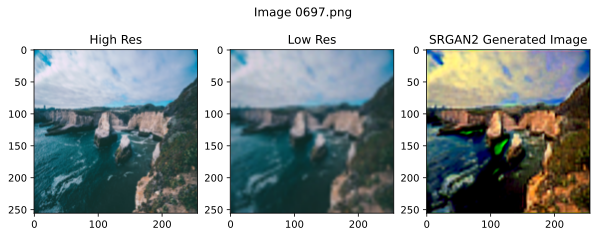

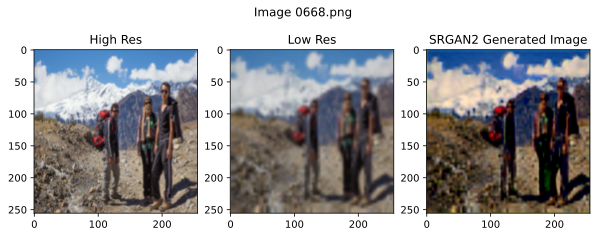

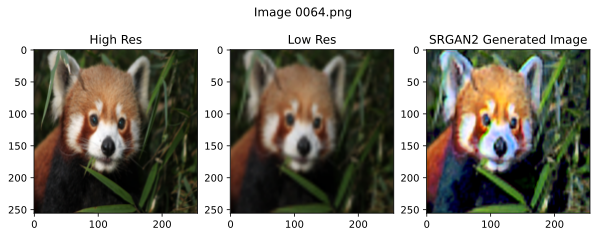

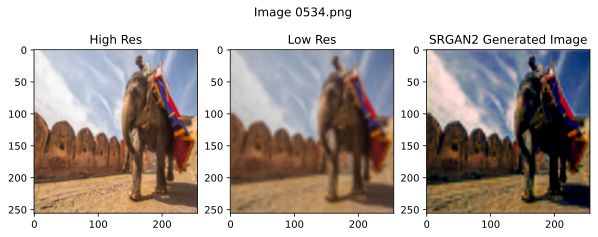

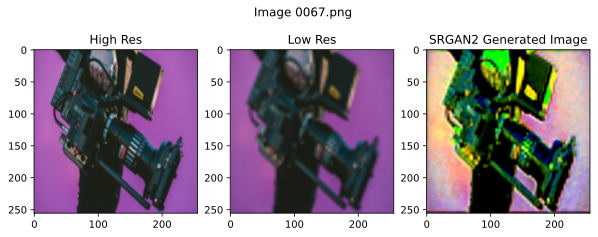

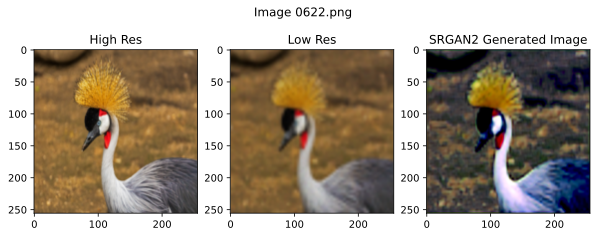

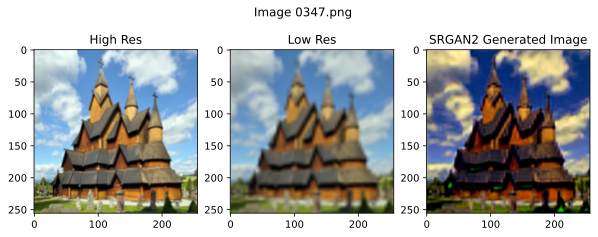

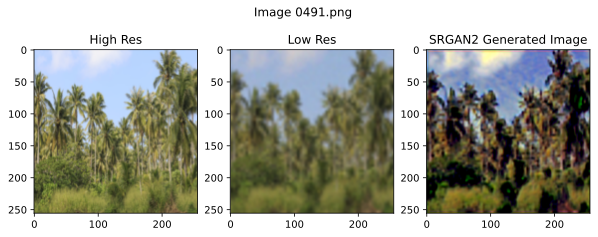

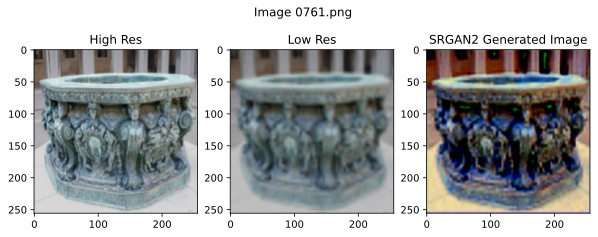

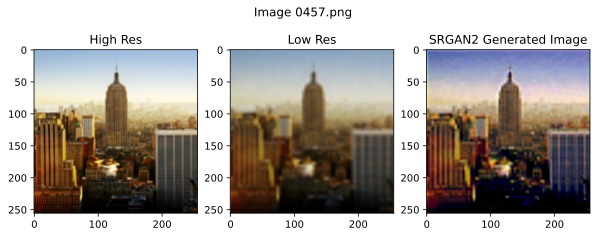

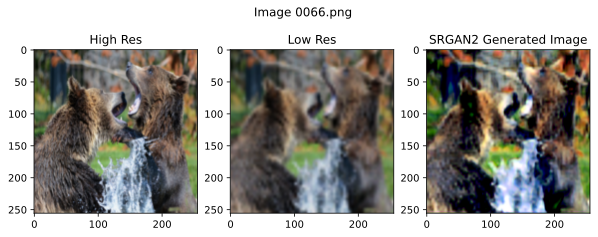

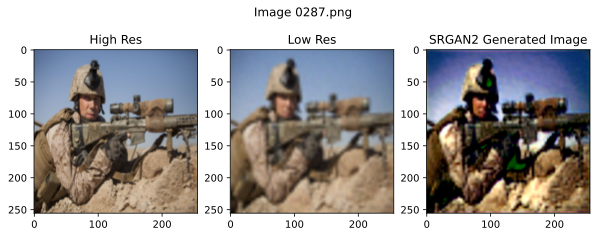

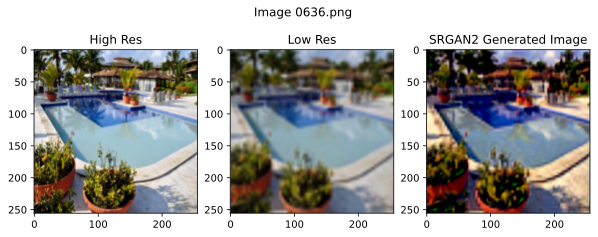

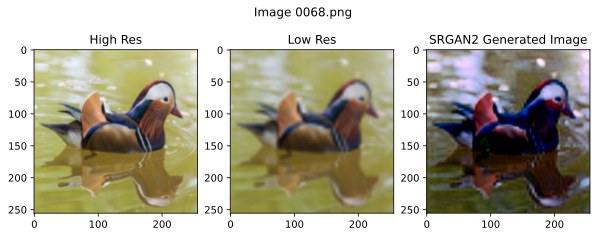

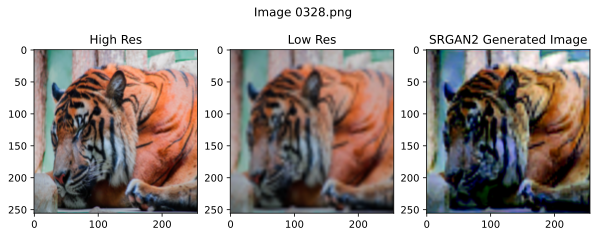

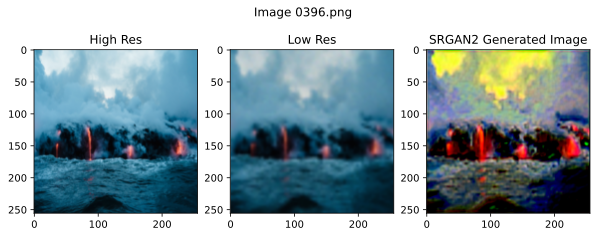

In [ ]:
#make static dataloader
_, test_paths = train_test_split(sorted(zip(sorted(hr_images),sorted(lr_images))), test_size=0.02, random_state=42)
test_dataloader = DataLoader(FacesDataset(test_paths), batch_size=1)

#build model
_, g_model = build_model()

#load the best model parameters
g_model.load_state_dict(torch.load(modelPath + 'best_g_model_srgan2.pkl')['model_state_dict'])

#generate and compare images
compare_imgs(test_dataloader, g_model)

# Plot Training Losses

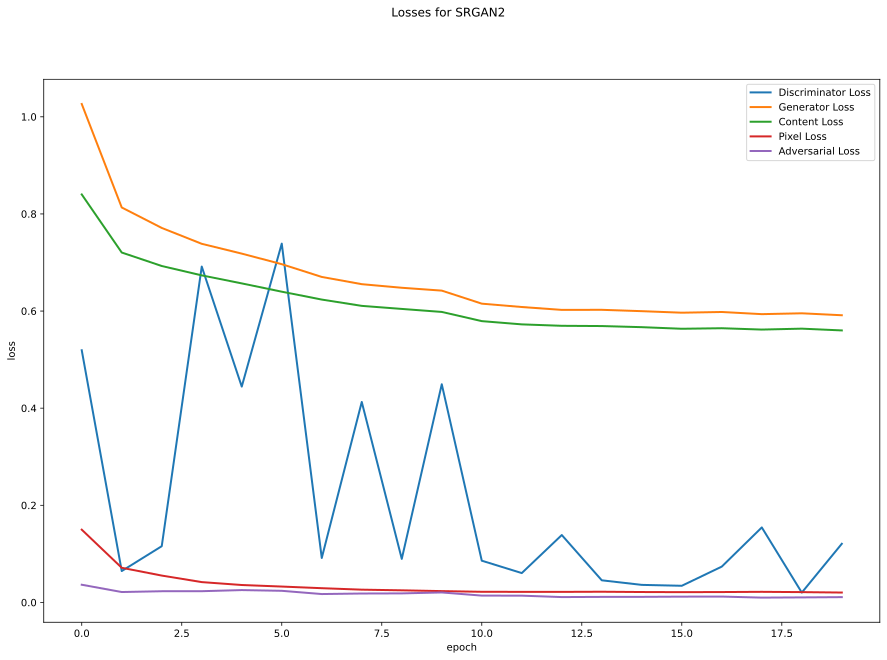

In [7]:
#read results file
df = pd.read_csv(resultPath + 'TrainSummary_' + modelName + '.csv')

#create list of losses
epochs = df['epoch'].tolist()
train_d_losses = df['train_d_loss'].tolist()
train_g_losses = df['train_g_loss'].tolist()
train_content_losses = df['train_content_loss'].tolist()
train_pixel_losses = df['train_pixel_loss'].tolist()
train_adversarial_losses = df['train_adversarial_loss'].tolist()


#Plot losses
fig, axs = plt.subplots(1, 1, sharex = True)

fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Losses for ' + modelName)

axs.plot(train_d_losses)
axs.plot(train_g_losses)
axs.plot(train_content_losses)
axs.plot(train_pixel_losses)
axs.plot(train_adversarial_losses)


#Label Axes and lines
axs.set_ylabel('loss')
axs.set_xlabel('epoch')
axs.legend(['Discriminator Loss', 'Generator Loss', 'Content Loss', 'Pixel Loss', 'Adversarial Loss'])

#save figure
fig.savefig(outputPath + 'lossVepoch_' + modelName + '.png')

fig.show()